In [1]:
# !pip install snowflake-connector-python

In [2]:
# !pip install wordcloud

In [3]:
import pandas as pd
import snowflake.connector
import os
from datetime import datetime
from dotenv import load_dotenv
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [1]:
import sys
import os

# Get the current working directory
current_directory = os.getcwd()

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(current_directory, '..')))

# Import the helper_functions module
from helper_functions import connect_to_snowflake, get_data, write_to_snowflake

# 1.1 Connect to Snowflake using schema ODS

In [2]:
conn = connect_to_snowflake(schema_name='ODS')

Successfully connected to Snowflake schema ODS


# 1.3 Data Preprocessing and Helper Functions

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /Users/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/alex/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alex/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
stop_words = set(stopwords.words('english'))

In [8]:
lemmatizer = WordNetLemmatizer()

In [9]:
# Text cleaning function
def clean_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize
    words = word_tokenize(text)
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]
        
    return ' '.join(words)

### 1.31 Wordcloud

In [10]:
def wordcloud(df):
    # Generate word cloud for cleaned comments
    text = ' '.join(df['clean_comments'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    return wordcloud

### 1.32 Sentiment Analysis

In [11]:
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to compute sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)['compound']


def apply_sentiment_score(df):
    # Apply sentiment analysis to each cleaned comment
    df['sentiment_score'] = df['clean_comments'].apply(get_sentiment_score)

    # Classify sentiment based on score
    df['sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))

### 1.33 Sentiment Distribution

In [12]:
def sentiment_distribution(df):
    df['sentiment'].value_counts().plot(kind='bar', figsize=(10, 5), color=['green', 'red', 'blue'])
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sentiment')
    plt.show()

### 1.34 Sentiment Scores Histogram

In [13]:
def sentiment_histogram(df):
    # Plot histogram of sentiment scores
    plt.figure(figsize=(10, 5))
    plt.hist(df['sentiment_score'], bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sentiment Scores')
    plt.show()

### 1.35 Trends over Time

In [14]:
def trends_over_time(df):
    # Convert REVIEW_DATE to datetime
    df['REVIEW_DATE'] = pd.to_datetime(df['REVIEW_DATE'])

    # Group by date and sentiment to count occurrences
    sentiment_trend = df.groupby([df['REVIEW_DATE'].dt.date, 'sentiment']).size().unstack().fillna(0)

    # Plot the trends over time
    sentiment_trend.plot(kind='line', figsize=(15, 7))
    plt.xlabel('Date')
    plt.ylabel('Number of Reviews')
    plt.title('Sentiment Trends Over Time')
    plt.show()

### 1.36 Bigram and Trigram

In [15]:
def ngram_analysis(df, n=2):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngrams = vectorizer.fit_transform(df['clean_comments'])
    ngram_counts = ngrams.sum(axis=0).tolist()[0]
    ngram_features = vectorizer.get_feature_names_out()
    
    ngram_freq = dict(zip(ngram_features, ngram_counts))
    sorted_ngrams = sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)[:20]
    
    ngrams, counts = zip(*sorted_ngrams)
    
    plt.figure(figsize=(10, 5))
    plt.bar(ngrams, counts)
    plt.xlabel(f'{n}-grams')
    plt.ylabel('Frequency')
    plt.title(f'Top 20 Most Common {n}-grams')
    plt.xticks(rotation=45, fontsize=10, ha='right')  # Set fontsize for x-ticks
    plt.tight_layout()
    plt.show()


# 2. Fetch data from Snowflake

In [16]:
# Function to get data
def fetch_data(query):
    try:
        # Execute the query and fetch the data into a DataFrame
        return(pd.read_sql(query, conn))
    
    except Exception as e:
        print(f"Failed to execute query due to error: {e}")

In [17]:
# SQL query to collect Albany data from the database
albany_query = '''
SELECT * FROM reviews
WHERE market = 'albany'
'''

albany_df = fetch_data(albany_query)
albany_df.head()

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


LISTING_ID       ID REVIEW_DATE  REVIEWER_ID  \
0     1489424  7208791  2013-09-10      5817914   
1     1489424  8001939  2013-10-12      4786919   
2     1489424  8123022  2013-10-16      4786919   
3     1489424  8279957  2013-10-23      8362214   
4     1489424  8303182  2013-10-24      9458270   

                                            COMMENTS  MARKET  
0  Efrat and Dan were very welcoming and accommod...  albany  
1  As advertised, a very comfy bed. Restful room,...  albany  
2  Glad to be back for a second time in my cozy r...  albany  
3  We stayed only for a night, so can not tell mu...  albany  
4  I had a pleasant stay here. The bed was indeed...  albany

# 3. Function to Run All Functions

In [18]:
def create_visualizations(city):
    # Enclose the city name in single quotes
    city_query = f"SELECT * FROM reviews WHERE market = '{city}';"
    
    city_df = fetch_data(city_query)
    
    city_df['clean_comments'] = city_df['COMMENTS'].apply(clean_text)
    city_df[['COMMENTS', 'clean_comments']]
        
    city_wordcloud = wordcloud(city_df)

    apply_sentiment_score(city_df)

    sentiment_histogram(city_df)

    sentiment_distribution(city_df)

    trends_over_time(city_df)
    
    ngram_analysis(city_df, n=2)
    
    ngram_analysis(city_df, n=3)

# 4. Perform Analysis on Each City

### 4.1 Albany

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


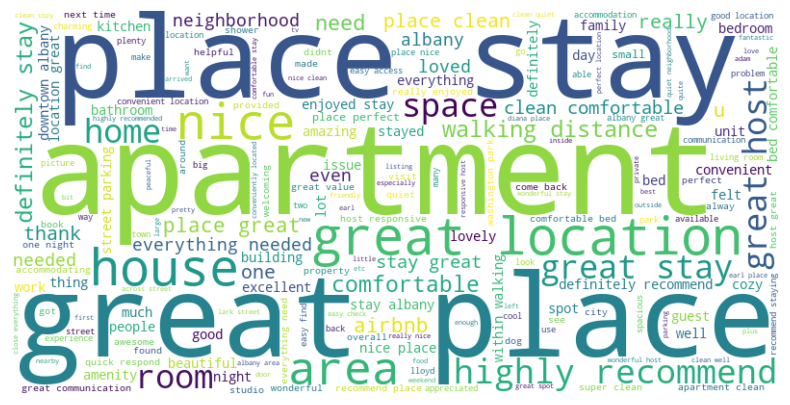

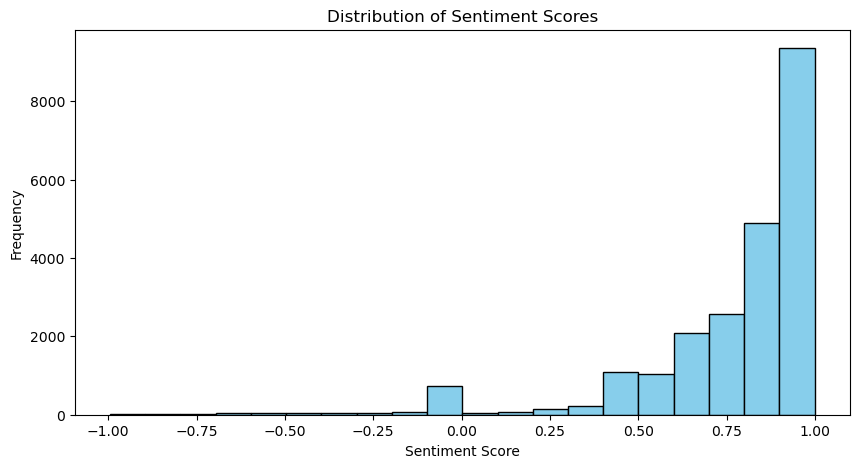

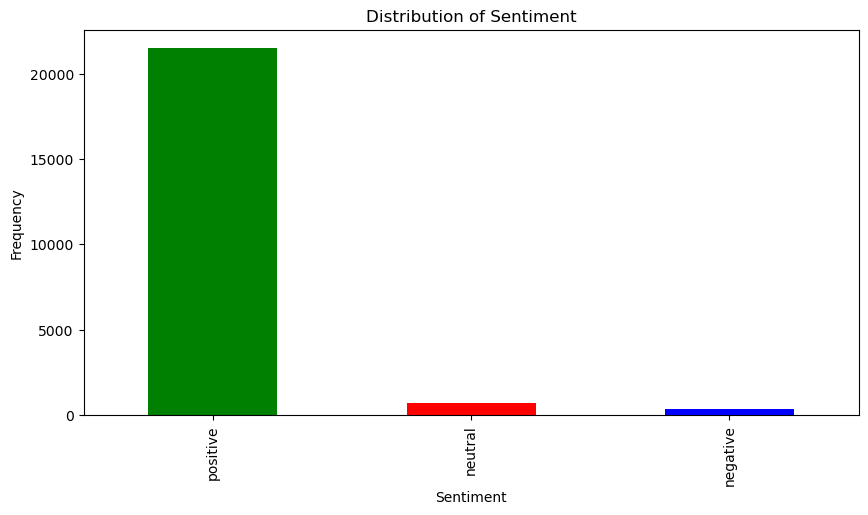

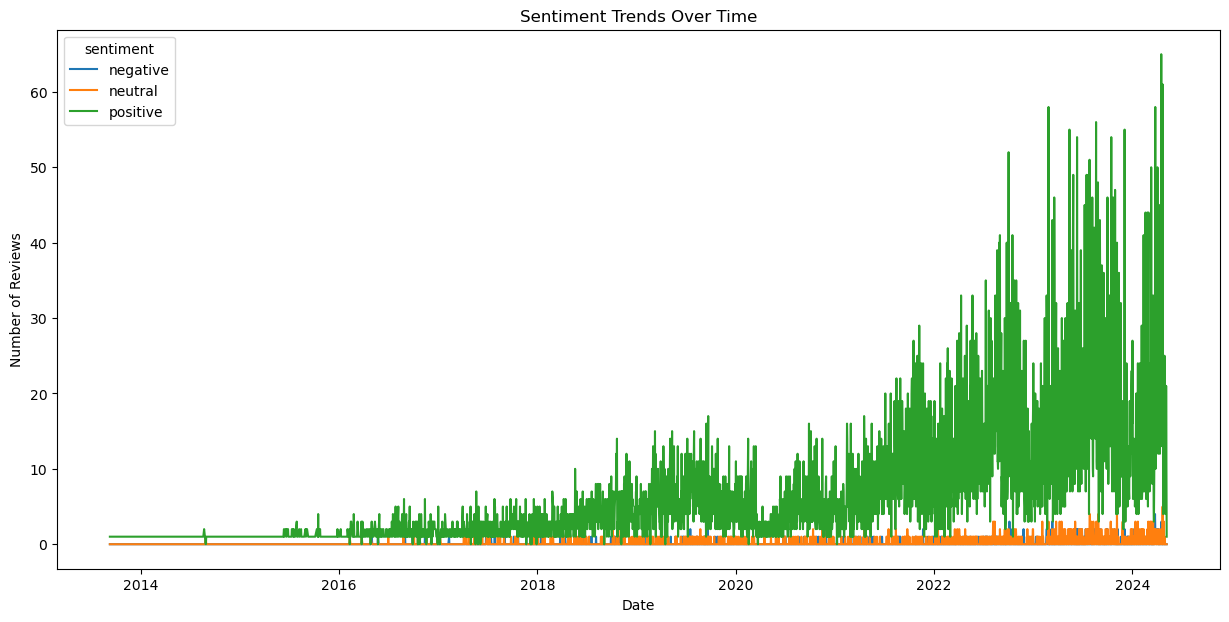

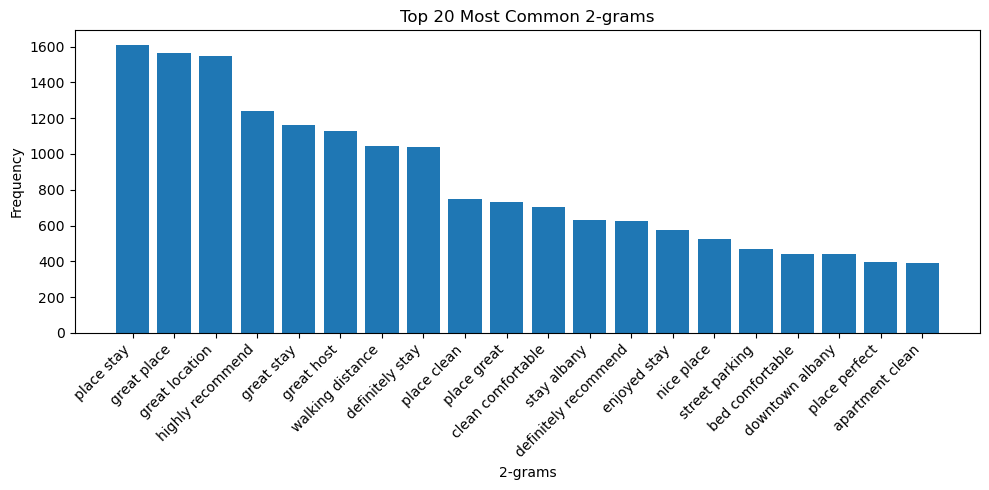

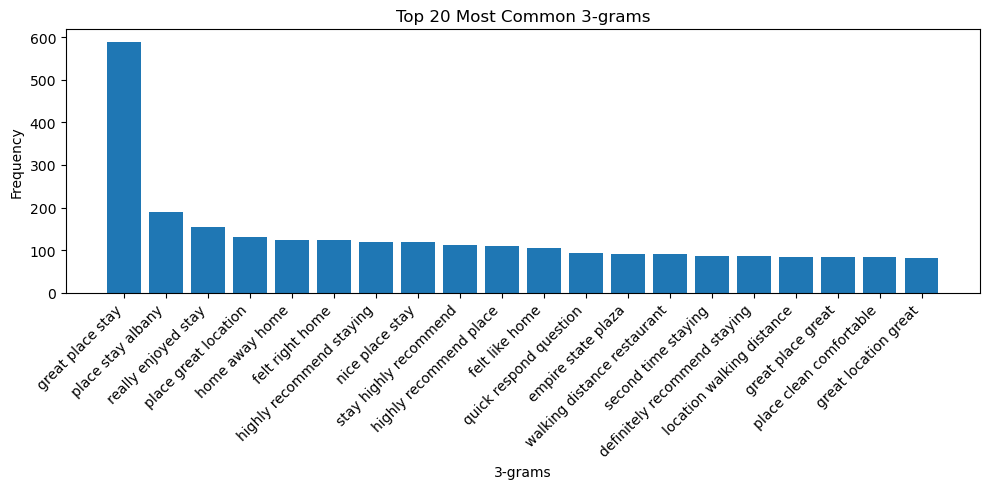

In [20]:
create_visualizations('albany')

### 4.2 Washington DC

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


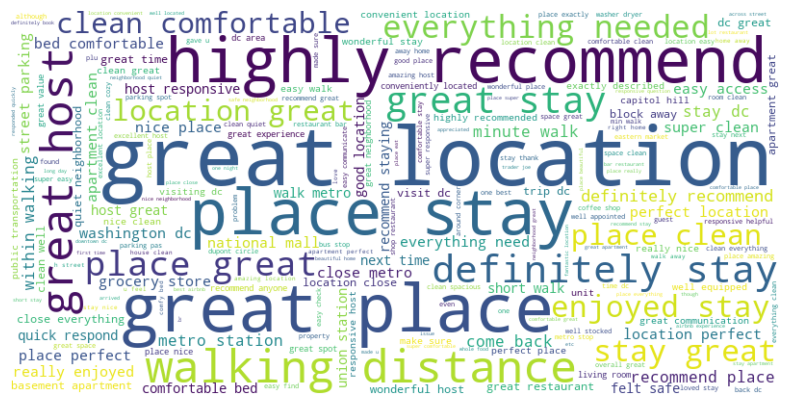

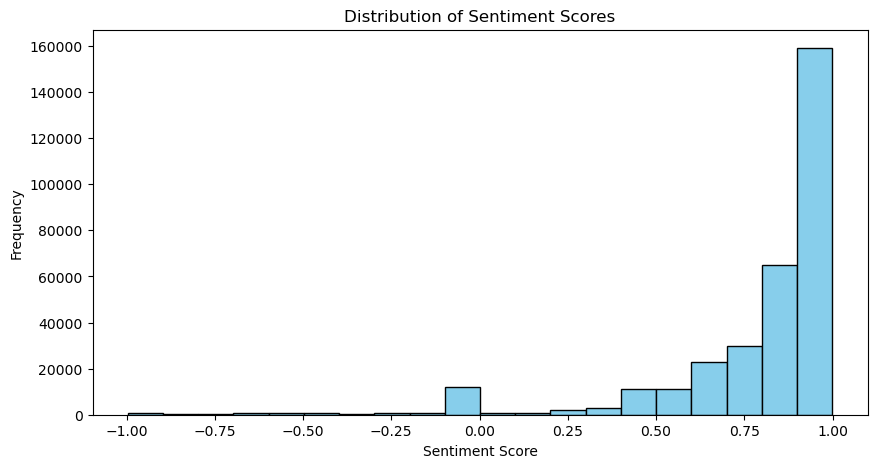

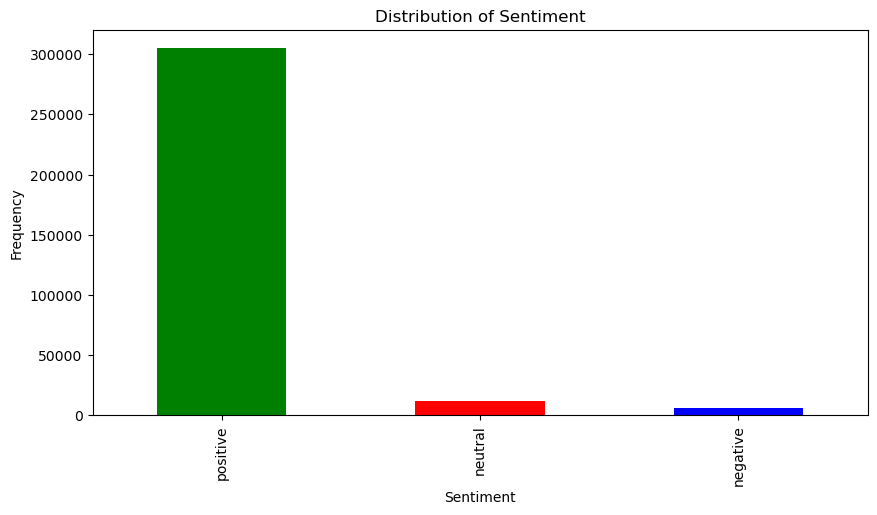

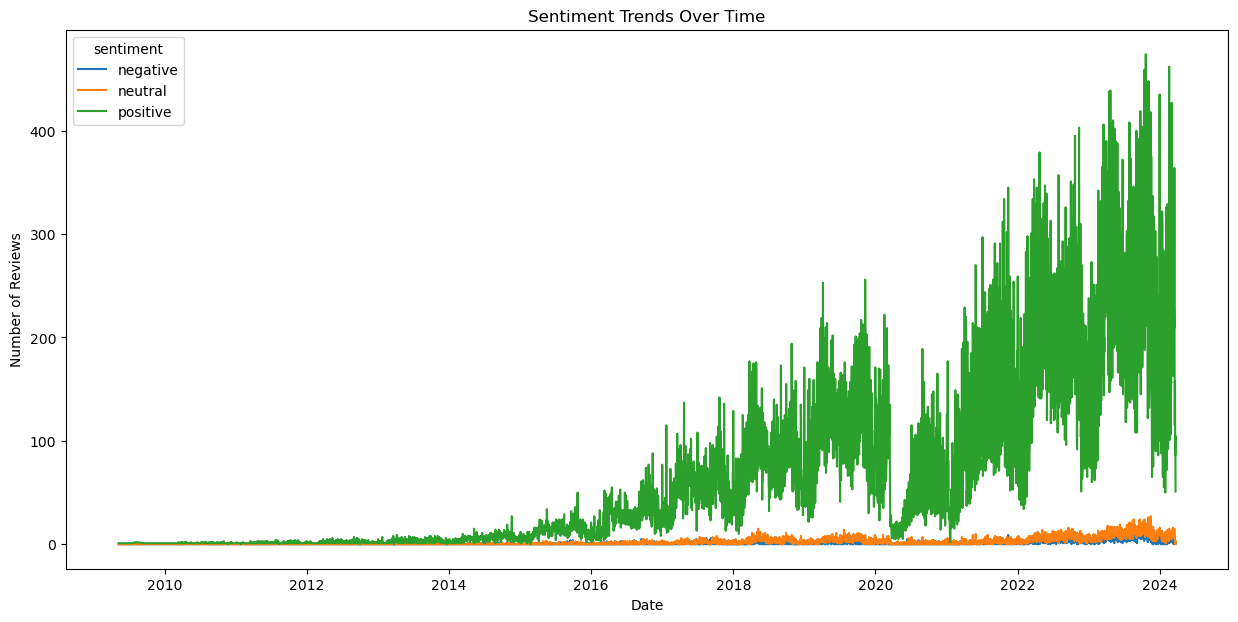

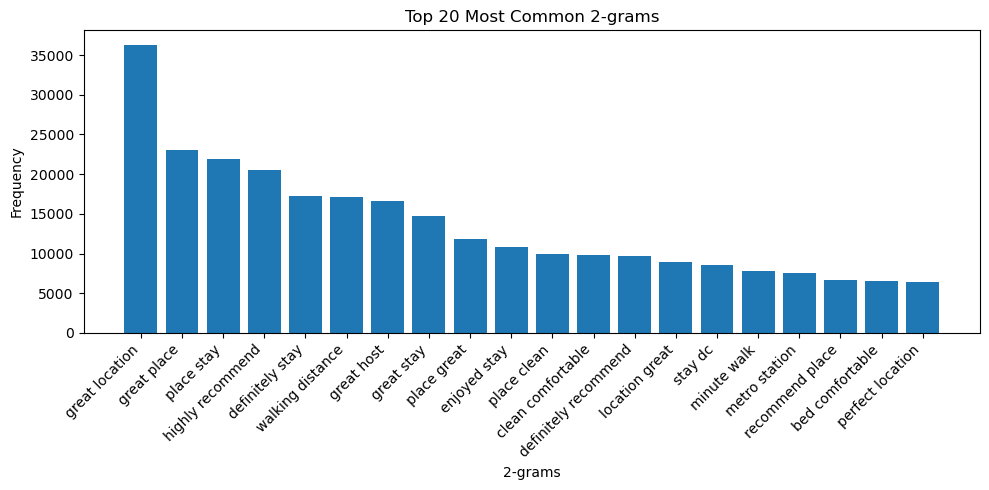

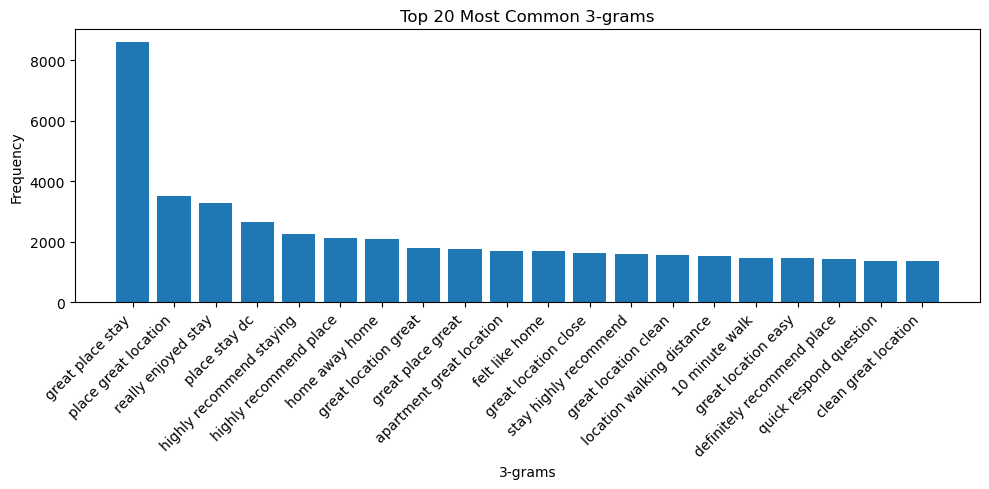

In [21]:
create_visualizations('washington-dc')

### 4.3 Los Angeles

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


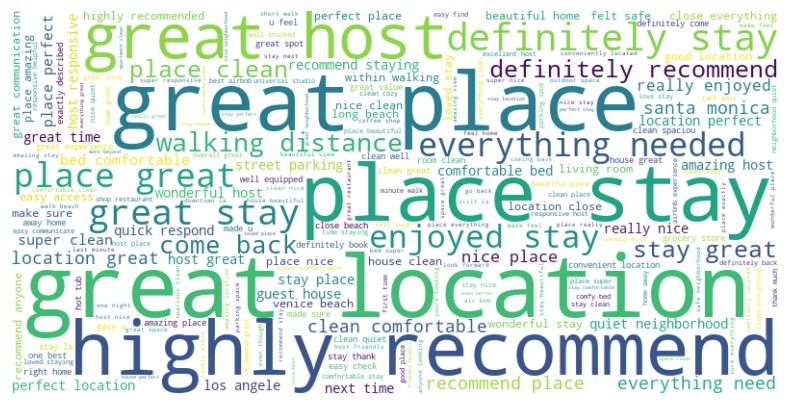

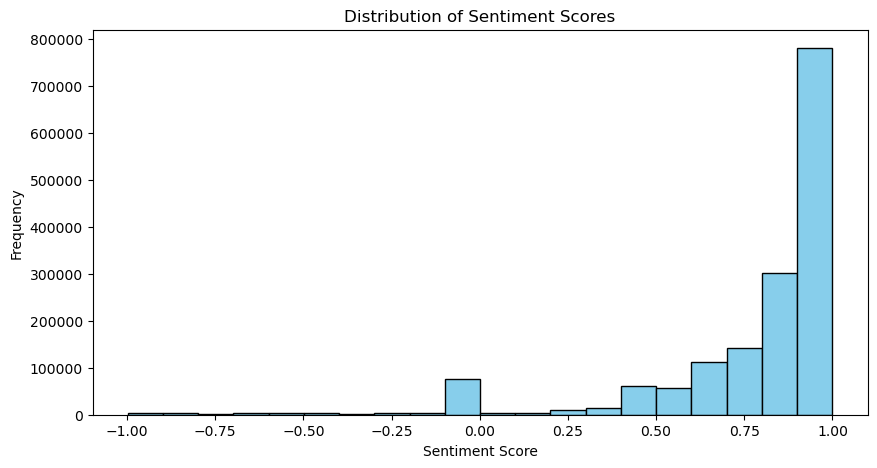

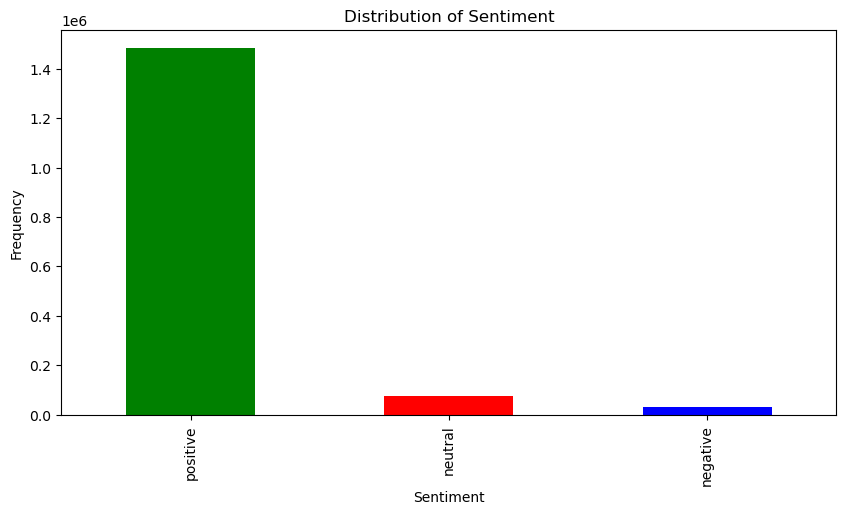

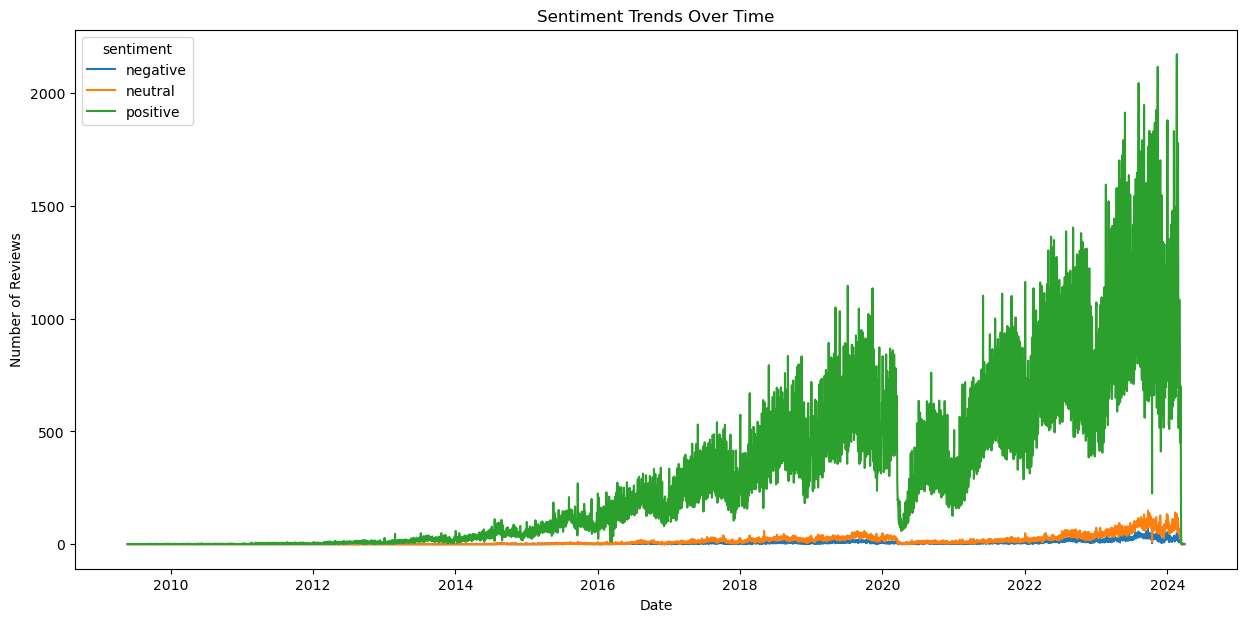

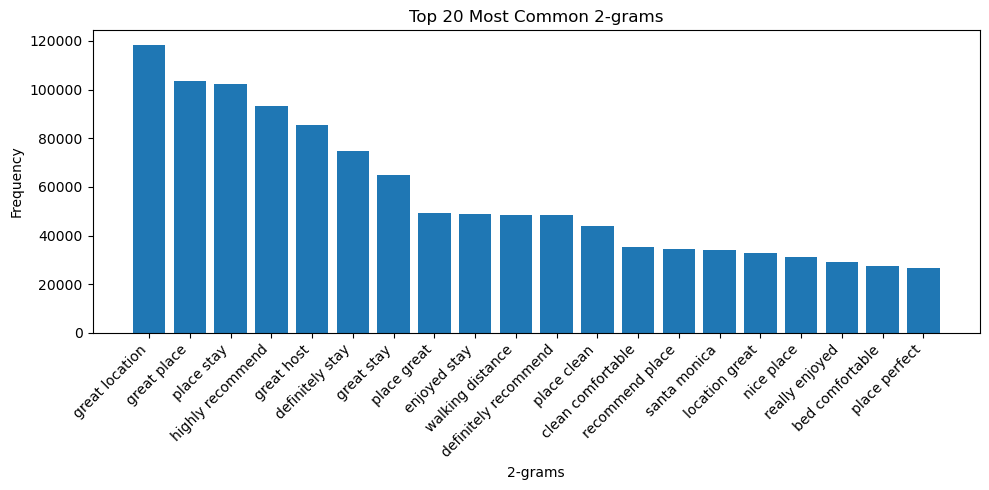

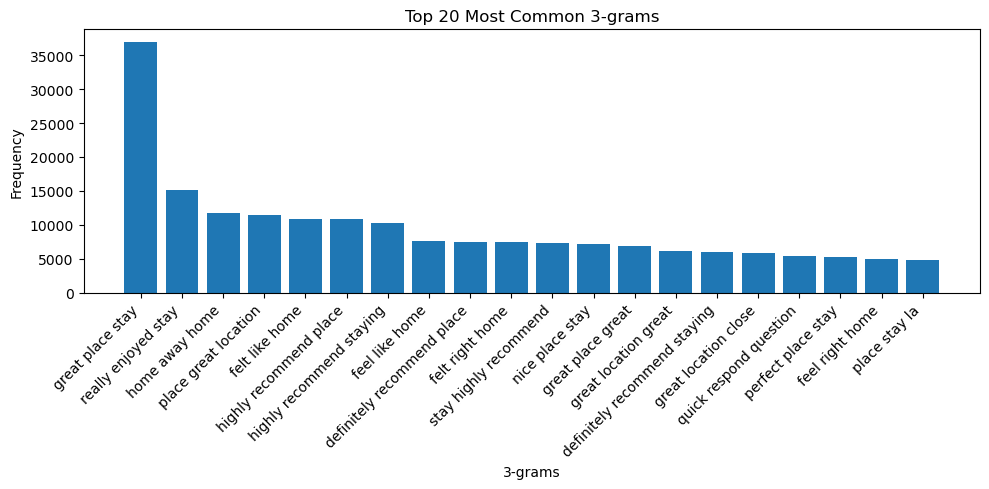

In [22]:
create_visualizations('los-angeles')

### 4.4 Chicago

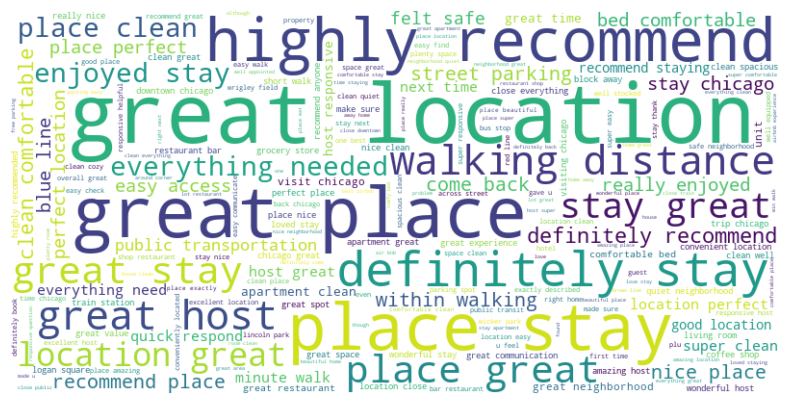

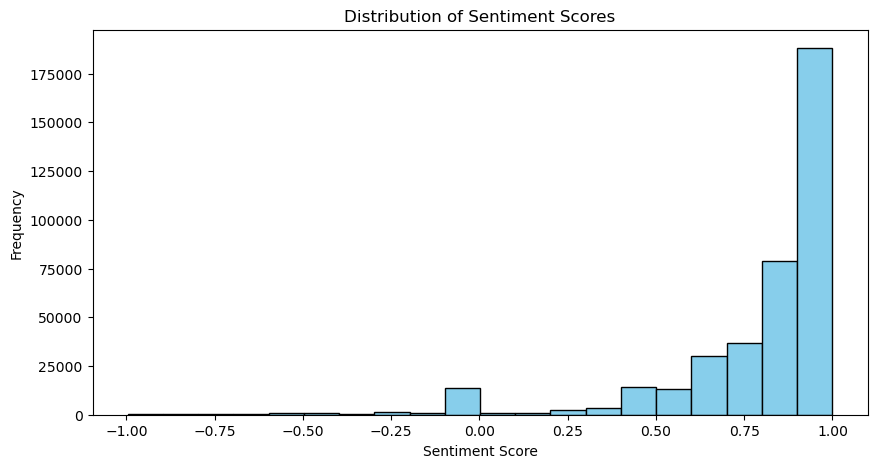

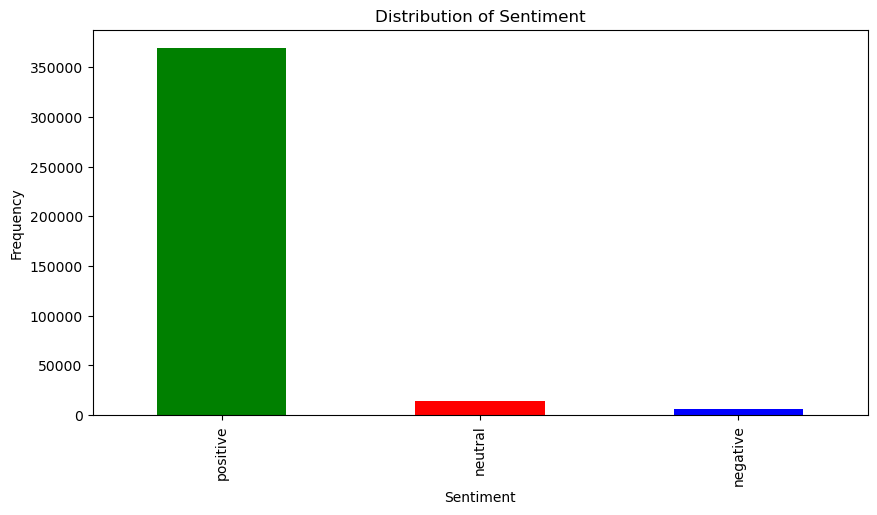

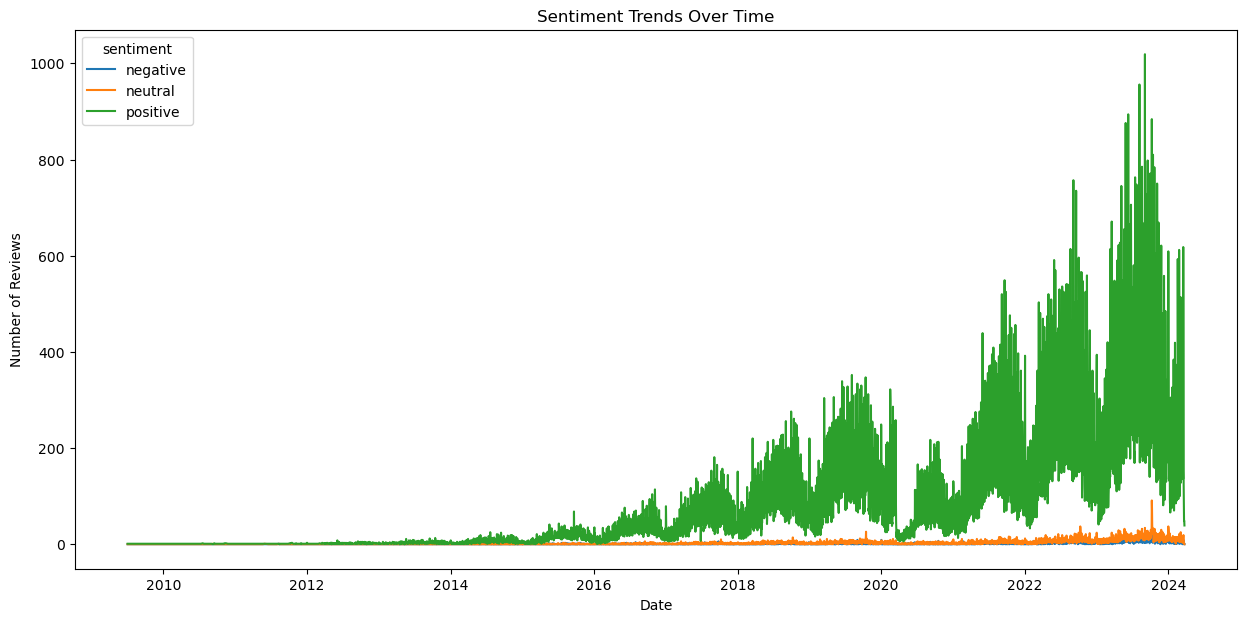

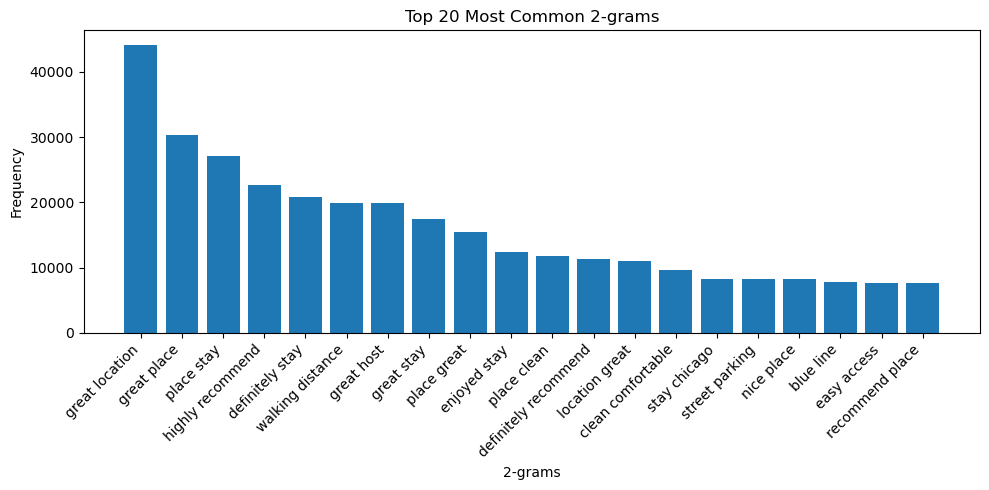

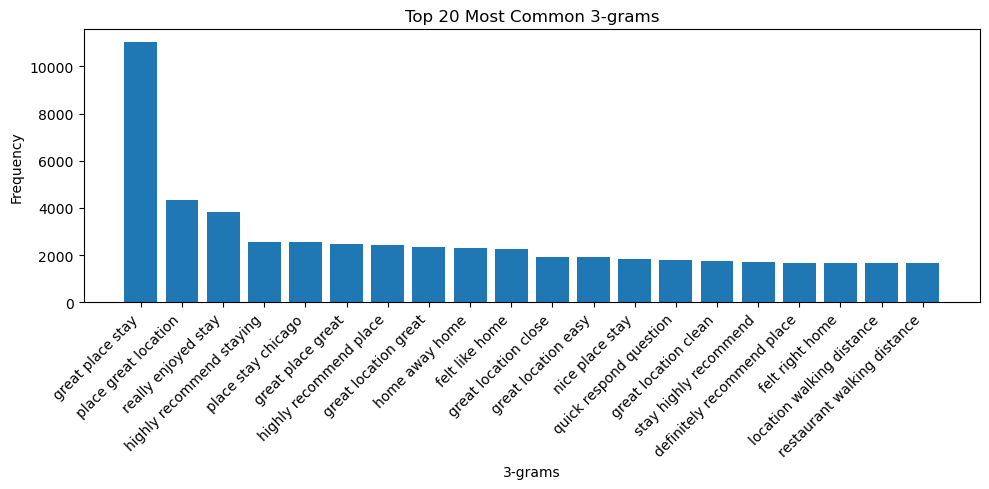

In [26]:
create_visualizations('chicago')

### 4.5 San Francisco

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


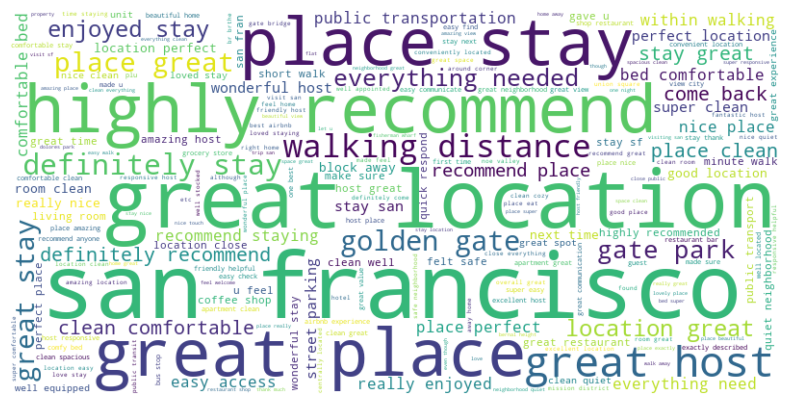

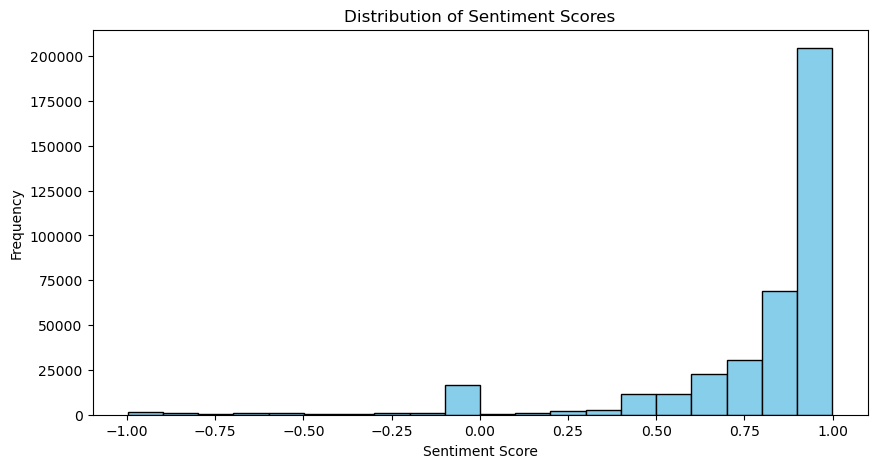

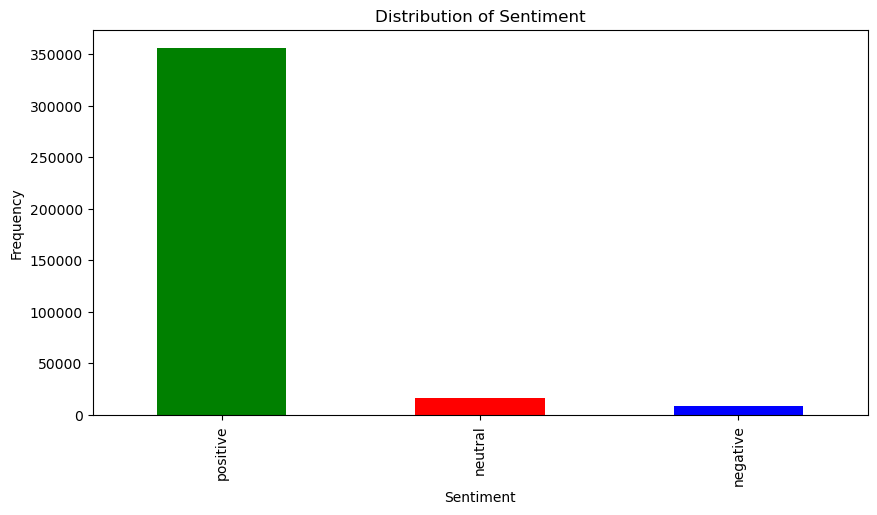

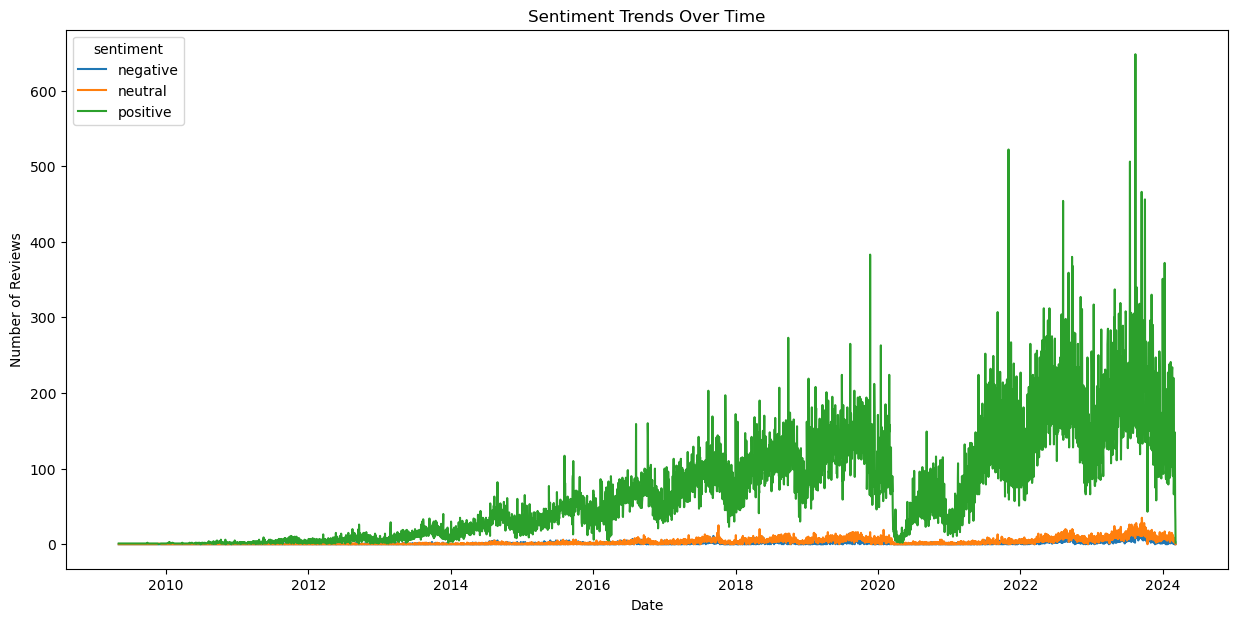

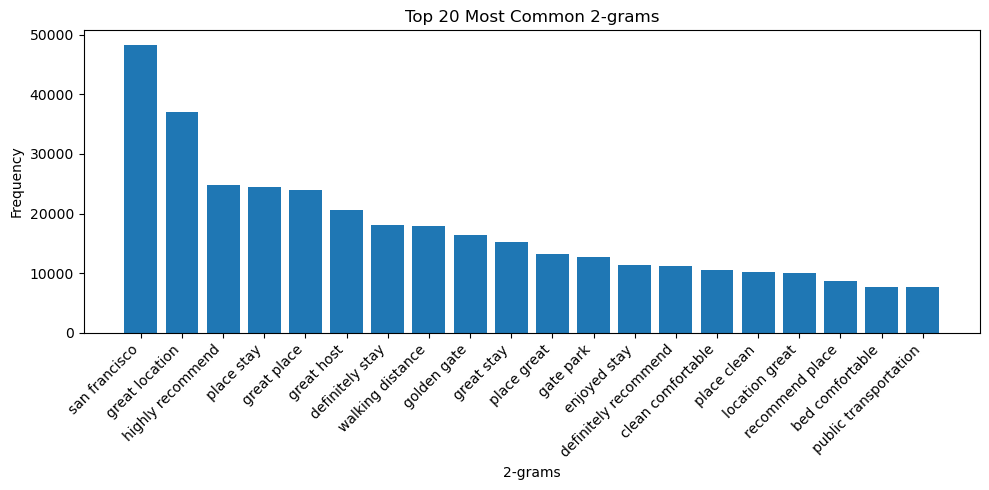

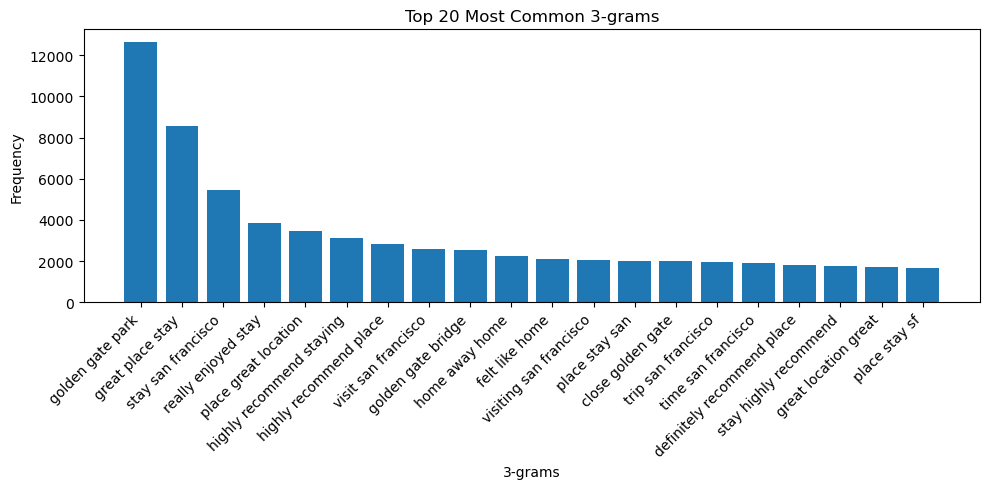

In [27]:
create_visualizations('san-francisco')

### 4.6 Seattle

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


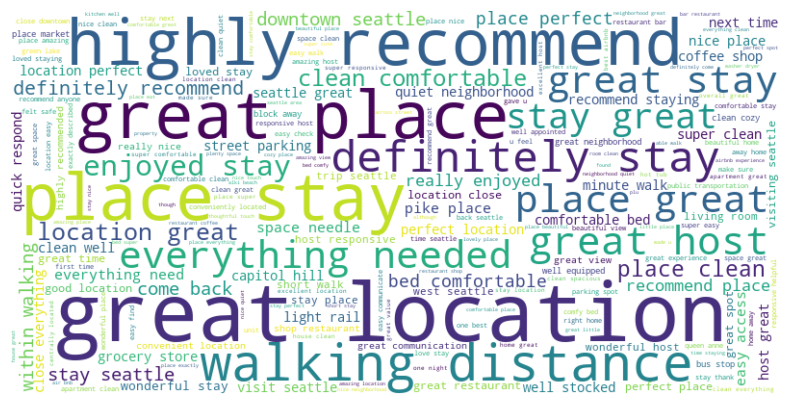

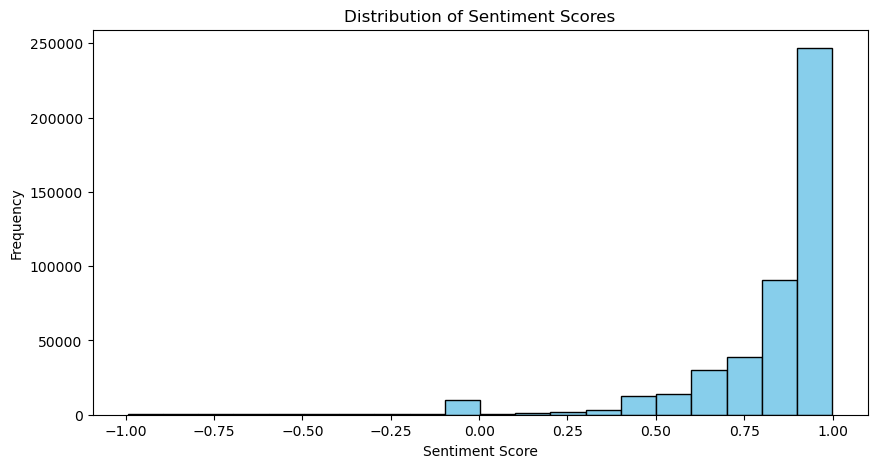

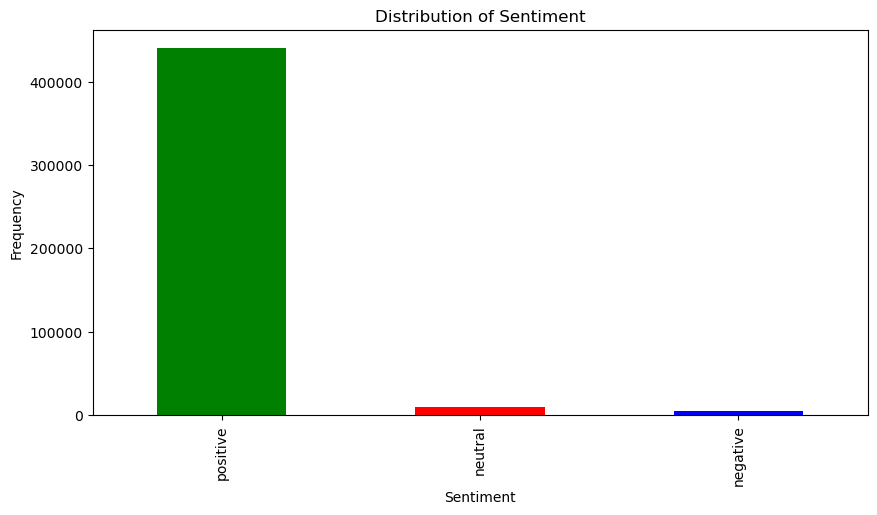

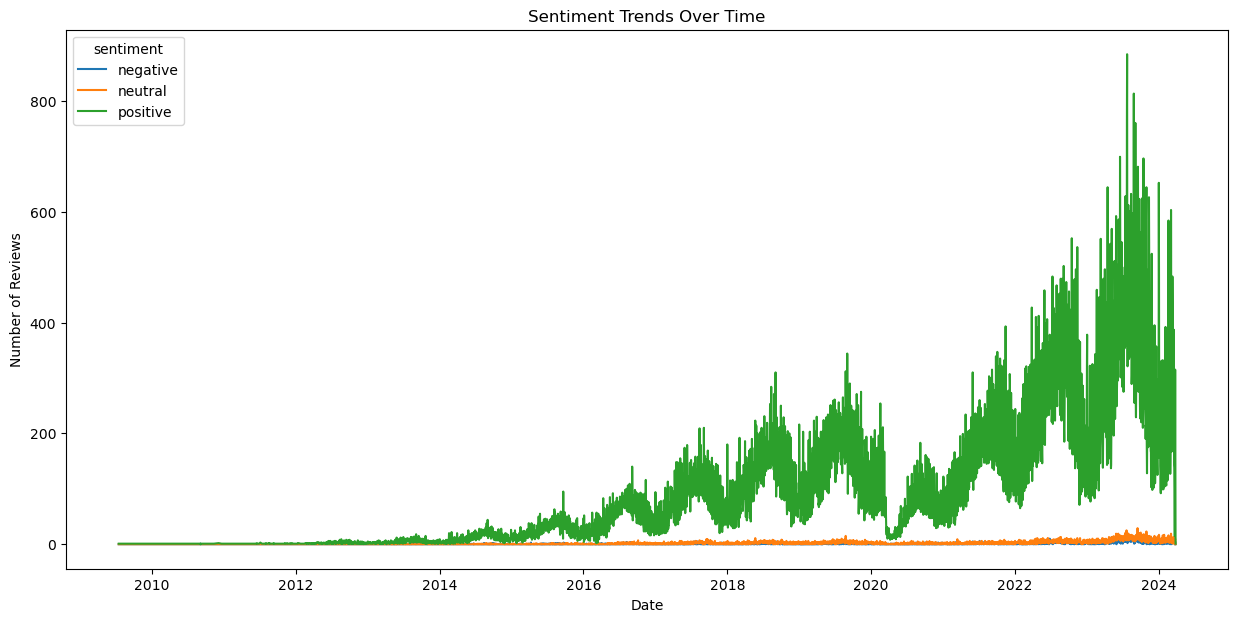

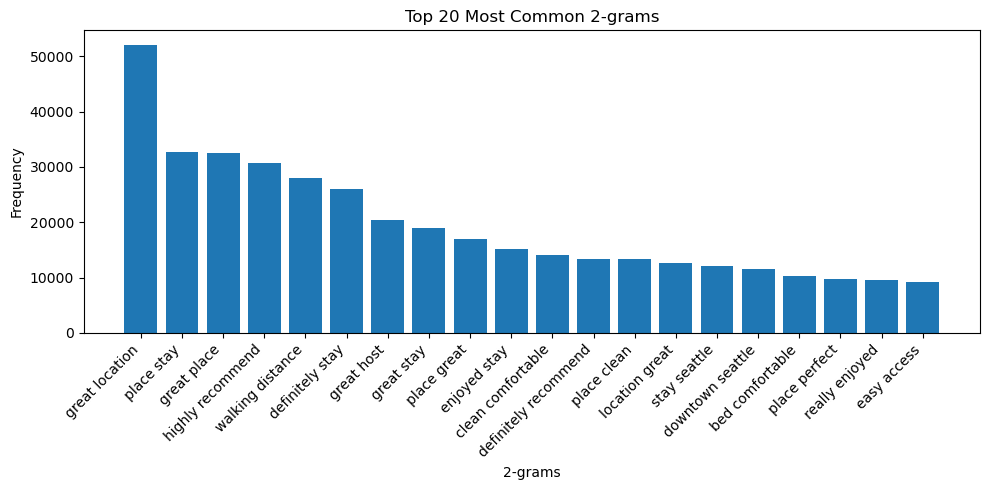

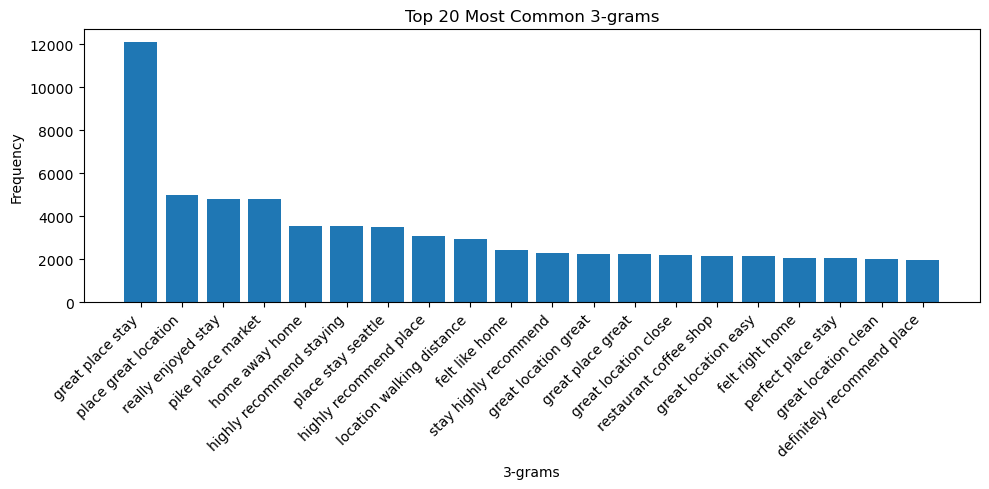

In [29]:
create_visualizations('seattle')

### 4.7 New York City

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


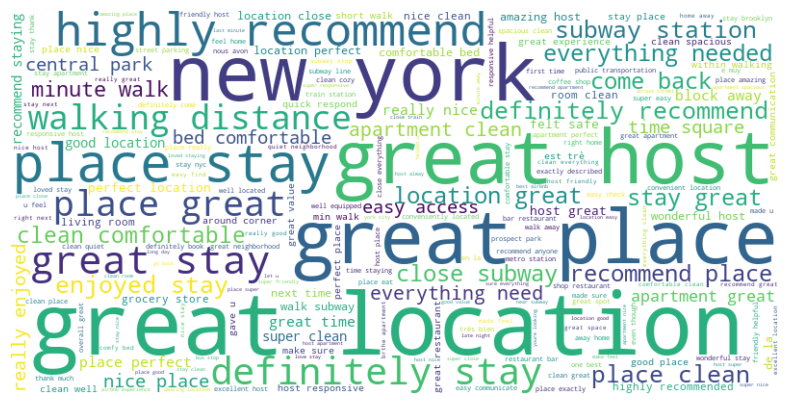

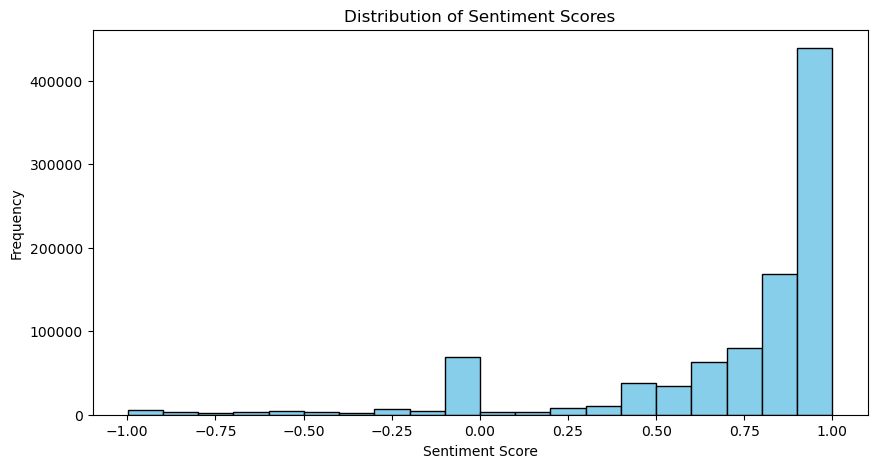

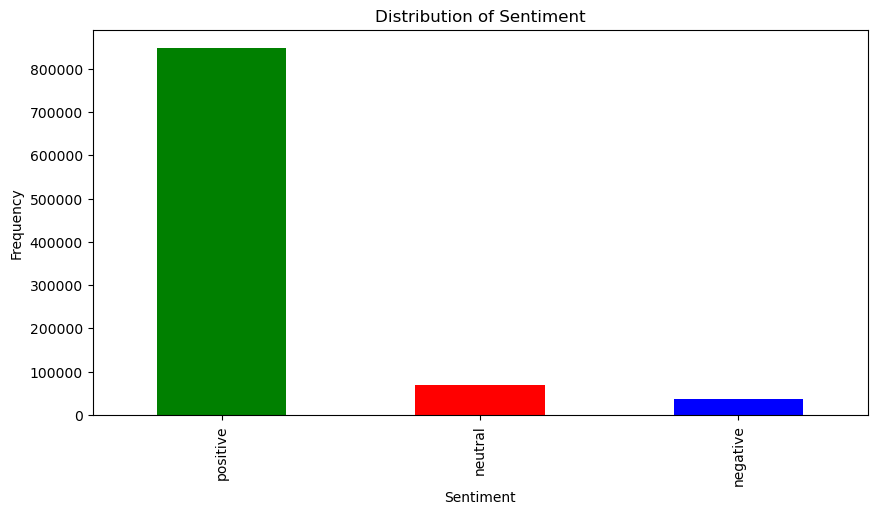

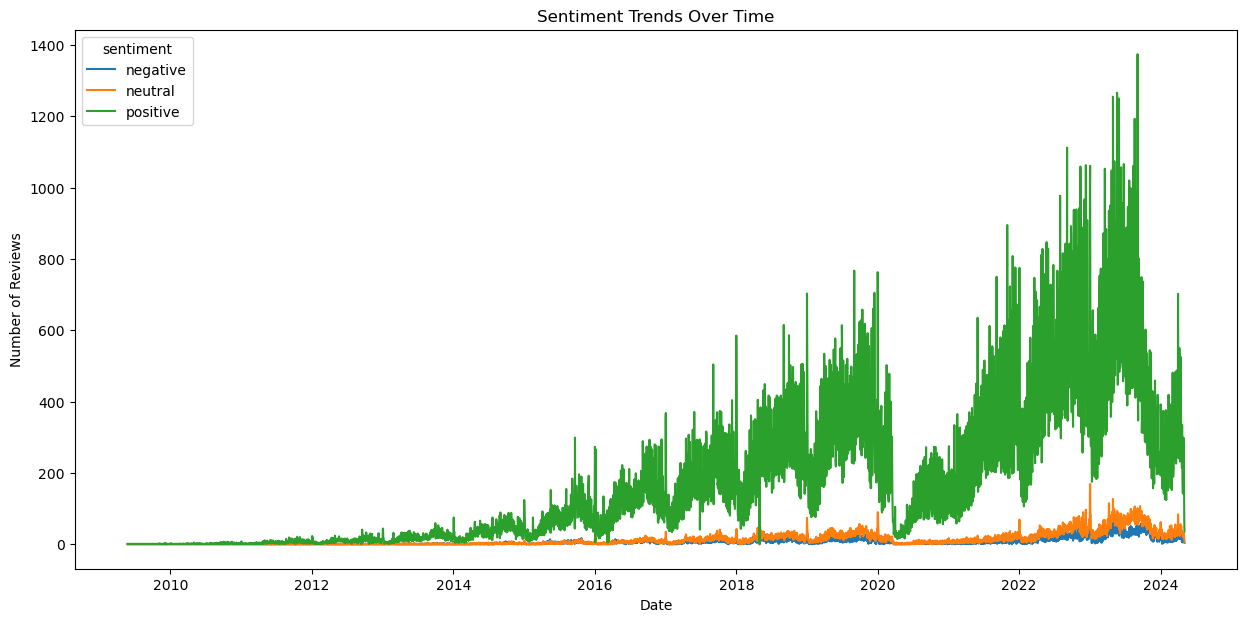

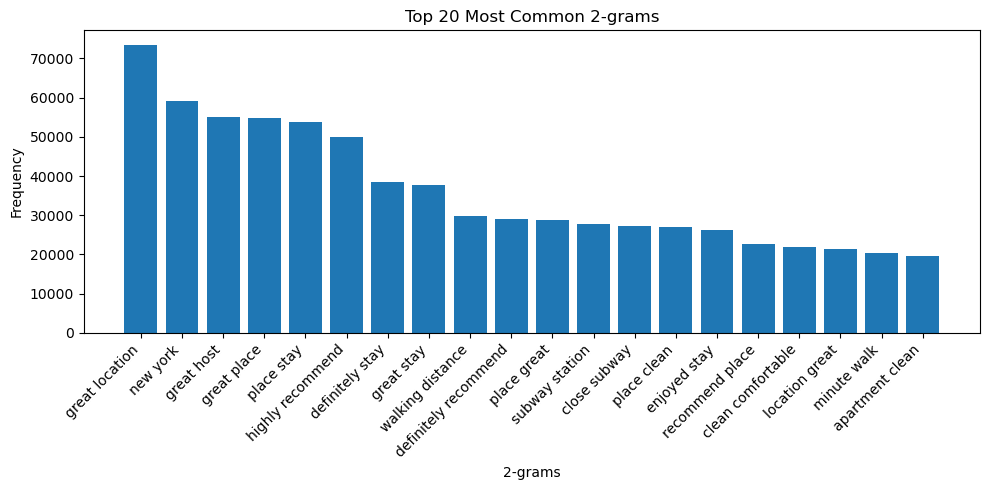

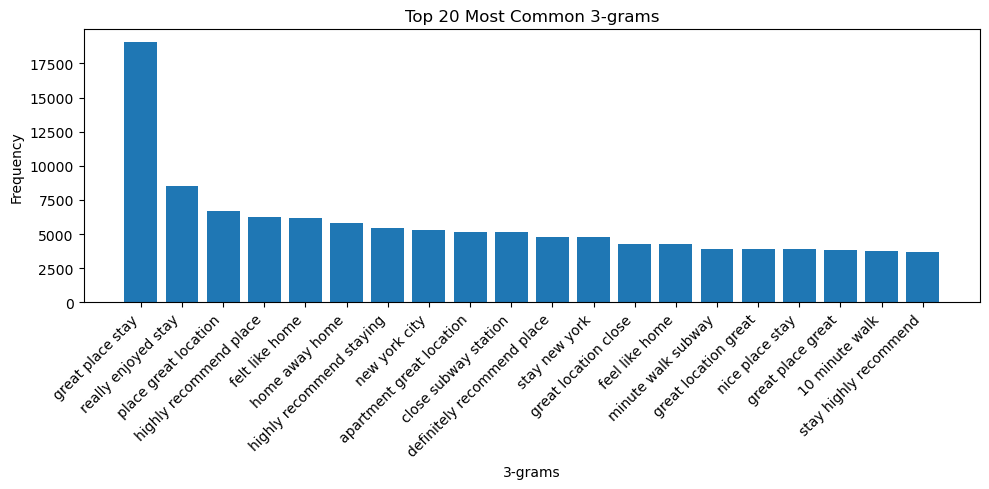

In [30]:
create_visualizations('new-york-city')

### Close connection to database

In [23]:
# conn.close()        
print("Snowflake connection closed.")

Snowflake connection closed.
